In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [2]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 33000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0', 'id', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min',\
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',\
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',\
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio',\
       'freq_qid1_x', 'freq_qid2_x', 'q1len_x', 'q2len_x', 'q1_n_words_x',\
       'q2_n_words_x', 'word_Common_x', 'word_Total_x', 'word_share_x',\
       'freq_q1+q2_x', 'freq_q1-q2_x', 'freq_qid1_y', 'freq_qid2_y', 'q1len_y',\
       'q2len_y', 'q1_n_words_y', 'q2_n_words_y', 'word_Common_y',\
       'word_Total_y', 'word_share_y', 'freq_q1+q2_y', 'freq_q1-q2_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

33000 rows
66000 rows
99000 rows
132000 rows


In [2]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [3]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [4]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [5]:
data=data.sort_values(by='index').reset_index(drop=True)
data.shape

(100001, 41)

In [6]:
data.head()

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y
0,1,NaN,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y
1,2,0.0,0,0,0.999980000399992,0.8333194446759221,0.9999833336111064,0.9999833336111064,0.9166590278414348,0.7857086735094749,...,1,66,57,14,12,10.0,23.0,0.43478260869565216,2,0
2,3,1.0,1,0,0.7999840003199936,0.3999960000399996,0.7499812504687383,0.5999880002399952,0.6999930000699993,0.4666635555762962,...,1,51,88,8,13,4.0,20.0,0.2,2,0
3,4,2.0,2,0,0.3999920001599968,0.3333277778703688,0.3999920001599968,0.24999687503906198,0.3999960000399996,0.28571224491253633,...,1,73,59,14,10,4.0,24.0,0.16666666666666666,2,0
4,5,3.0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,50,65,11,9,0.0,19.0,0.0,2,0


In [7]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0','index','is_duplicate'], axis=1, inplace=True)

In [8]:
data.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y
1,0,0.999980000399992,0.8333194446759221,0.9999833336111064,0.9999833336111064,0.9166590278414348,0.7857086735094749,0.0,1.0,2.0,...,1,66,57,14,12,10.0,23.0,0.43478260869565216,2,0
2,1,0.7999840003199936,0.3999960000399996,0.7499812504687383,0.5999880002399952,0.6999930000699993,0.4666635555762962,0.0,1.0,5.0,...,1,51,88,8,13,4.0,20.0,0.2,2,0
3,2,0.3999920001599968,0.3333277778703688,0.3999920001599968,0.24999687503906198,0.3999960000399996,0.28571224491253633,0.0,1.0,4.0,...,1,73,59,14,10,4.0,24.0,0.16666666666666666,2,0
4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1,50,65,11,9,0.0,19.0,0.0,2,0
5,4,0.3999920001599968,0.19999800001999984,0.9999500024998748,0.6666444451851604,0.5714204082798817,0.3076899408466089,0.0,1.0,6.0,...,1,76,39,13,7,2.0,20.0,0.1,2,0


In [9]:
data.shape

(100000, 38)

<h2> 4.2 Converting strings to numerics </h2>

In [10]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric) #,errors='coerce' #df.loc[pd.isnull(df).any(1),:]
    print(i)

id
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1_x
freq_qid2_x
q1len_x
q2len_x
q1_n_words_x
q2_n_words_x
word_Common_x
word_Total_x
word_share_x
freq_q1+q2_x
freq_q1-q2_x
freq_qid1_y
freq_qid2_y
q1len_y
q2len_y
q1_n_words_y
q2_n_words_y
word_Common_y
word_Total_y
word_share_y
freq_q1+q2_y
freq_q1-q2_y


In [11]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

In [12]:
Counter(y_true)

Counter({0: 62746, 1: 37254})

In [13]:
#len(np.where(X_train.iloc[:,:]==0)[1])

In [14]:
dff = pd.read_csv(r"F:\New folder\train.csv",nrows=100000)
dff['question1'] = dff['question1'].apply(lambda x: str(x))
dff['question2'] = dff['question2'].apply(lambda x: str(x))

In [15]:
dff.shape

(100000, 6)

In [16]:
dff.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [17]:
df1  = dff.merge(data, on='id',how='left')

In [18]:
final_data=df1.drop(['id','qid1','qid2','is_duplicate'],axis=1)

In [19]:
final_data.shape

(100000, 39)

In [20]:
final_data.head()

,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,1,76,39,13,7,2.0,20.0,0.100000,2,0


<h2> 4.3 Random train test split( 70:30) </h2>

In [21]:
x_train,x_test, y_train, y_test = train_test_split(final_data, y_true, stratify=y_true, test_size=0.3)

In [22]:
print("Number of data points in train data :",x_train.shape)
print("Number of data points in test data :",x_test.shape)

Number of data points in train data : (70000, 39)
Number of data points in test data : (30000, 39)


In [23]:
vect1 = TfidfVectorizer(lowercase=False)
vect2 = TfidfVectorizer(lowercase=False)
vect1.fit(list(x_train['question1']))
vect2.fit(list(x_train['question2']))

x_trn_tfidfq1 = vect1.transform(list(x_train['question1']))
x_trn_tfidfq2 = vect2.transform(list(x_train['question2']))
x_tst_tfidfq1 = vect1.transform(list(x_test['question1']))
x_tst_tfidfq2 = vect2.transform(list(x_test['question2']))

In [24]:
x_trn_tfidfq1.shape,x_tst_tfidfq1.shape,x_trn_tfidfq2.shape,x_tst_tfidfq2.shape

((70000, 36741), (30000, 36741), (70000, 34314), (30000, 34314))

In [25]:
x_train.head(1)

,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y
6646,How do I use condom?,How do I use a condom effectively?,0.99995,0.666644,0.999967,0.749981,0.99998,0.714276,0.0,1.0,...,1,20,34,5,7,4.0,12.0,0.333333,3,1


In [26]:
x_train=x_train.drop(['question1','question2'],axis=1)
x_test=x_test.drop(['question1','question2'],axis=1)

from scipy.sparse import csr_matrix,hstack
x_trn_feat=csr_matrix((x_train))
x_tst_feat=csr_matrix((x_test))

In [27]:
X_train = hstack([x_trn_feat,x_trn_tfidfq1,x_trn_tfidfq2]) # final x_train
X_test = hstack([x_tst_feat,x_tst_tfidfq1,x_tst_tfidfq2])  #final x_test

In [28]:
from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
stand.fit(X_train)
X_train=stand.transform(X_train)
X_test=stand.transform(X_test)

In [29]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


In [30]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8901398294244052


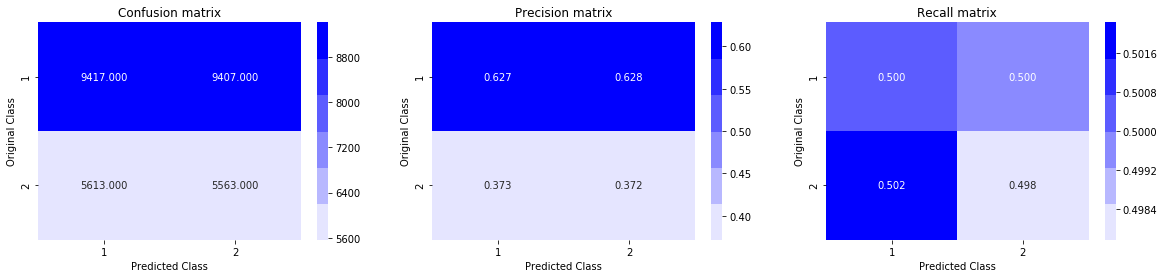

In [31]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4701052542345344
For values of alpha =  0.0001 The log loss is: 0.4726008706699696
For values of alpha =  0.001 The log loss is: 0.4605967790918947
For values of alpha =  0.01 The log loss is: 0.48758036701846624
For values of alpha =  0.1 The log loss is: 0.5099509694216503
For values of alpha =  1 The log loss is: 0.5341202335909714
For values of alpha =  10 The log loss is: 0.5777266715250184


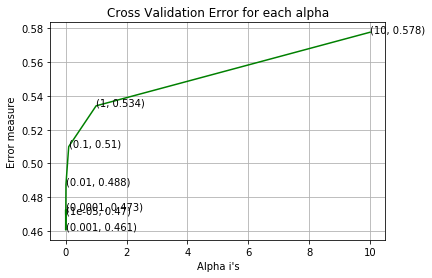

For values of best alpha =  0.001 The train log loss is: 0.45534276269260215
For values of best alpha =  0.001 The test log loss is: 0.4605967790918947
Total number of data points : 30000


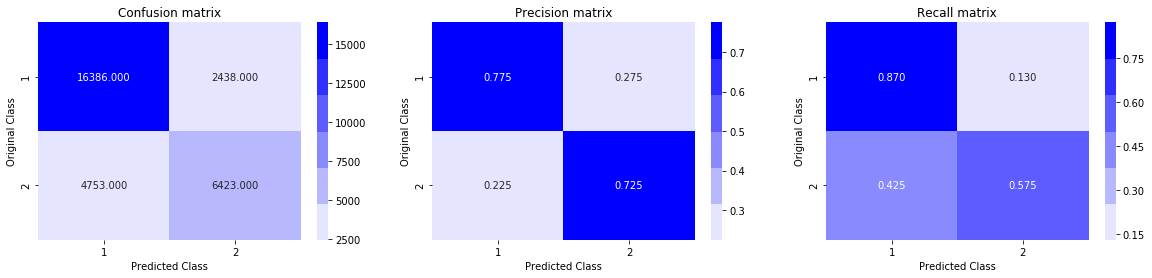

In [32]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.469085742438749
For values of alpha =  0.0001 The log loss is: 0.48019235895121626
For values of alpha =  0.001 The log loss is: 0.5144013768761873
For values of alpha =  0.01 The log loss is: 0.501555655568449
For values of alpha =  0.1 The log loss is: 0.5398161993659664
For values of alpha =  1 The log loss is: 0.620521295296497


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  10 The log loss is: 0.6524935782145297


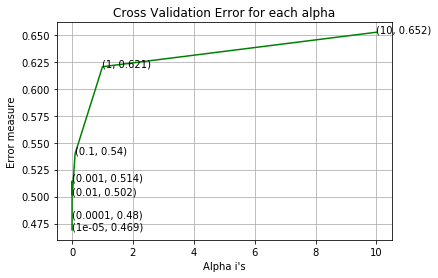

For values of best alpha =  1e-05 The train log loss is: 0.46219640031620507
For values of best alpha =  1e-05 The test log loss is: 0.469085742438749
Total number of data points : 30000


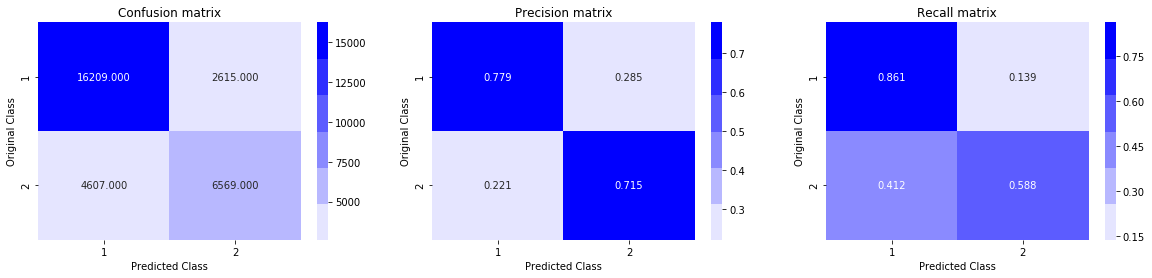

In [33]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [34]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.685541	test-logloss:0.685606
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.623505	test-logloss:0.623929
[20]	train-logloss:0.578307	test-logloss:0.579087
[30]	train-logloss:0.544294	test-logloss:0.545467
[40]	train-logloss:0.518027	test-logloss:0.519518
[50]	train-logloss:0.497418	test-logloss:0.499177
[60]	train-logloss:0.481246	test-logloss:0.483293
[70]	train-logloss:0.468065	test-logloss:0.470392
[80]	train-logloss:0.457462	test-logloss:0.459983
[90]	train-logloss:0.448977	test-logloss:0.451764
[100]	train-logloss:0.441712	test-logloss:0.444695
[110]	train-logloss:0.435593	test-logloss:0.438789
[120]	train-logloss:0.430337	test-logloss:0.433761
[130]	train-logloss:0.425656	test-logloss:0.429277
[140]	train-logloss:0.421601	test-logloss:0.425471
[150]	train-logloss:0.41835	test-logloss:0.422464
[160]	train-logloss:0.415582	test-logloss:0.419

Total number of data points : 30000


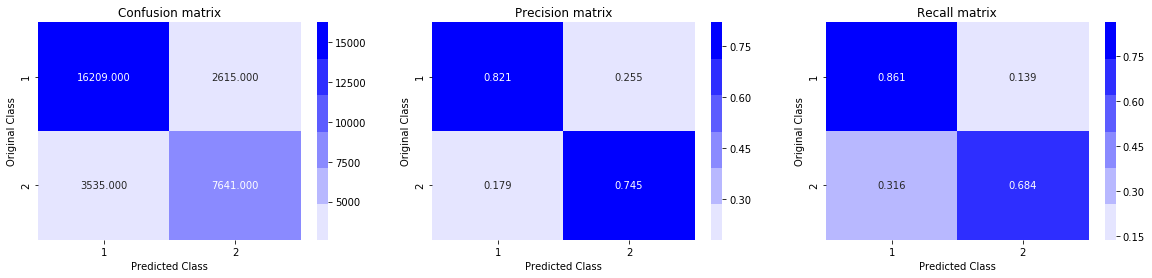

In [35]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss

In [37]:
from sklearn.model_selection import RandomizedSearchCV
#define rf parameters
xgb_params={'max_depth':range(3,10,2),\
           'min_child_weight':range(1,6,2),\
           'n_estimators':range(5,150,25)}
#define rf grid search
xgb=XGBClassifier(objective= 'binary:logistic',learning_rate =0.1)
xgb_grid=RandomizedSearchCV(xgb,xgb_params,scoring='neg_log_loss',cv=5)

xgb_model_two=xgb_grid.fit(X_train,y_train)

In [84]:
xgb_grid.best_params_

{'n_estimators': 105, 'min_child_weight': 3, 'max_depth': 9}

In [85]:
xgb_grid.best_score_

-0.36243288144026964

In [86]:
y_predpro_xgb = xgb_model_two.predict_proba(X_test)
#print(y_predpro_xgb)

print('Log_loss using xgboost Random_search method',log_loss(y_test,y_predpro_xgb)) 

Log_loss using xgboost Random_search method 0.36182971706108463


<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


# Conclusion:

**STEPS and OBSERVATIONS learnt from this case study:**

1. Identified the main objective as: 
    * Identify which questions asked on Quora are duplicates of questions that have already been asked.
    * This could be useful to instantly provide answers to questions that have already been answered.
    * We are tasked with predicting whether a pair of questions are duplicates or not.
2. since the features obtained might be insufficient for the prediction, simple and advanced features were added.
3. simple TFIDF features obtained are nearly 36,822. for large dimensions logistic regression and linear-SVM works well.
4. After hyperparameter tuning the least log_loss we got is **0.3618**.

In [90]:
from prettytable import PrettyTable
w=PrettyTable()
w.field_names=['model','logloss']
w.add_row(['worst case model',0.883632])
w.add_row(['logistic Regression',0.44529])
w.add_row(['linear_SVM',0.4634])
w.add_row(['xgboost without parameter tuning',0.3927])
w.add_row(['xgboost with parameter tuning',0.36182])
print(w)

+----------------------------------+----------+
|              model               | logloss  |
+----------------------------------+----------+
|         worst case model         | 0.883632 |
|       logistic Regression        | 0.44529  |
|            linear_SVM            |  0.4634  |
| xgboost without parameter tuning |  0.3927  |
|  xgboost with parameter tuning   | 0.36182  |
+----------------------------------+----------+
